드랍아웃

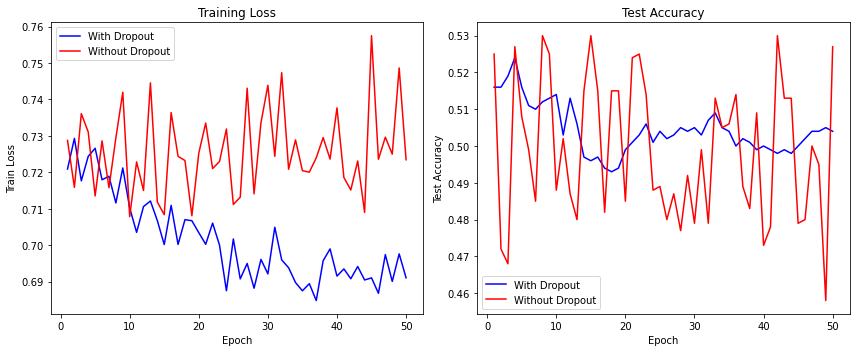

In [5]:
import torch
import torch.nn as nn #신경망 클래스 +활성손실 + 초기화 +옵티마이저 +기타등등
import torch.optim as optim # 종류가 다른가?
import matplotlib.pyplot as plt


# 데이터 생성
torch.manual_seed(42)  # 재현성을 위해 시드 설정
num_samples = 1000
num_features = 10
X_train = torch.randn(num_samples, num_features)
y_train = torch.randint(0, 2, (num_samples,))

X_test = torch.randn(num_samples, num_features)
y_test = torch.randint(0, 2, (num_samples,)) 


# 모델 정의
class DropoutNet(nn.Module):
    def __init__(self):
        super(DropoutNet, self).__init__() #
        self.fc1 = nn.Linear(num_features, 50) # 
        self.dropout = nn.Dropout(p=0.5)  # 드
        self.fc2 = nn.Linear(50, 2) # 

    def forward(self, x):
        x = torch.relu(self.fc1(x)) #
        x = self.dropout(x)  #  
        x = self.fc2(x) #
        return x

# 모델 초기화 및 손실 함수, 최적화 함수 설정
model = DropoutNet() 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 함수 정의
def train(model, X_train, y_train, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    return loss.item()

# 평가 함수 정의
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_test).sum().item()
        accuracy = correct / y_test.size(0)
    return accuracy

# 모델 학습 및 평가
num_epochs = 50

train_losses = []
test_accuracies = []
train_losses_without_dropout = []
test_accuracies_without_dropout = []

for epoch in range(num_epochs):
    train_loss = train(model, X_train, y_train, optimizer, criterion)
    test_accuracy = evaluate(model, X_test, y_test)
    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)

    # 드랍아웃을 적용하지 않은 경우의 정확도 측정
    model_without_dropout = DropoutNet()
    optimizer_without_dropout = optim.Adam(model_without_dropout.parameters(), lr=0.001)
    train_loss_without_dropout = train(model_without_dropout, X_train, y_train, optimizer_without_dropout, criterion)
    test_accuracy_without_dropout = evaluate(model_without_dropout, X_test, y_test)
    train_losses_without_dropout.append(train_loss_without_dropout)
    test_accuracies_without_dropout.append(test_accuracy_without_dropout)

# 그래프 그리기
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# 학습 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='With Dropout')
plt.plot(epochs, train_losses_without_dropout, 'r-', label='Without Dropout')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss')
plt.legend()

# 테스트 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, 'b-', label='With Dropout')
plt.plot(epochs, test_accuracies_without_dropout, 'r-', label='Without Dropout')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#구현방식이 다르다. 
#그냥 드랍아웃으로 똑같이 해도 될건데 하나는 직접 구현하고 하나는 드랍아웃을 받아와서 그냥 값을 0으로 준 것

강제종료

Early stopping at epoch 14 with test accuracy 0.5240


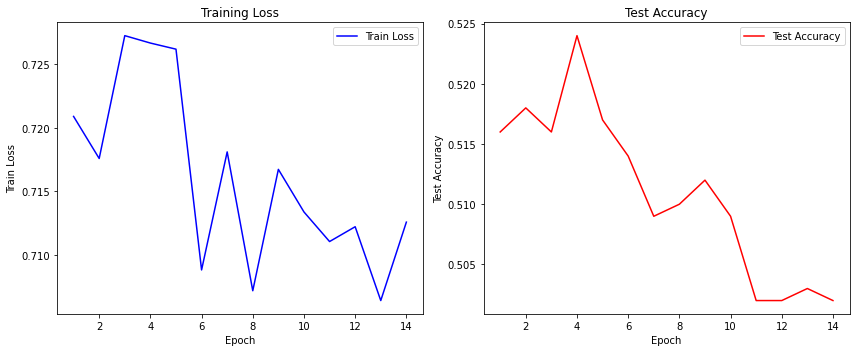

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 데이터 생성
torch.manual_seed(42)  # 재현성을 위해 시드 설정
num_samples = 1000
num_features = 10
X_train = torch.randn(num_samples, num_features)
y_train = torch.randint(0, 2, (num_samples,))

X_test = torch.randn(num_samples, num_features)
y_test = torch.randint(0, 2, (num_samples,))

# 모델 정의
class DropoutNet(nn.Module):
    def __init__(self):
        super(DropoutNet, self).__init__()
        self.fc1 = nn.Linear(num_features, 50)
        self.dropout = nn.Dropout(p=0.5)  # 드랍아웃 추가
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # 드랍아웃 적용
        x = self.fc2(x)
        return x

# 모델 초기화 및 손실 함수, 최적화 함수 설정
model = DropoutNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 함수 정의
def train(model, X_train, y_train, X_test, y_test, optimizer, criterion, max_epochs=100, early_stopping_rounds=10):
    model.train()
    train_losses = []
    test_accuracies = []
    best_test_accuracy = 0.0
    early_stopping_counter = 0
    
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # 평가
        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == y_test).sum().item()
            test_accuracy = correct / y_test.size(0)
            test_accuracies.append(test_accuracy)
            
            # 과적합 감지 및 조기 종료
            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            
            if early_stopping_counter >= early_stopping_rounds:
                print(f'Early stopping at epoch {epoch+1} with test accuracy {best_test_accuracy:.4f}')
                break
        
        model.train()
    
    return train_losses, test_accuracies

# 모델 학습
train_losses, test_accuracies = train(model, X_train, y_train, X_test, y_test, optimizer, criterion)

# 그래프 그리기
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# 학습 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss')
plt.legend()

# 테스트 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
import numpy as np

def dropout_layer(input_data, dropout_prob):
    """
    드롭아웃 레이어 구현
    
    Parameters:
    input_data (numpy array): 드롭아웃을 적용할 입력 데이터 (형상: (batch_size, num_units))
    dropout_prob (float): 드롭아웃 확률 (0과 1 사이의 값)
    
    Returns:
    output_data (numpy array): 드롭아웃이 적용된 출력 데이터
    mask (numpy array): 드롭아웃 마스크 (1: 유지, 0: 드롭아웃 적용) (형상: (batch_size, num_units))
    """
    mask = np.random.binomial(1, 1 - dropout_prob, size=input_data.shape) / (1 - dropout_prob)
    output_data = input_data * mask
    return output_data, mask

# 예제: 드롭아웃을 적용할 입력 데이터
input_data = np.array([[1.0, 2.0, 3.0],
                       [4.0, 5.0, 6.0]])

# 드롭아웃 확률 설정
dropout_prob = 0.2

# 드롭아웃 레이어 적용
output_data, mask = dropout_layer(input_data, dropout_prob)

print("입력 데이터:")
print(input_data)
print("\n드롭아웃 적용 후 출력 데이터:")
print(output_data)
print("\n드롭아웃 마스크:")
print(mask)


입력 데이터:
[[1. 2. 3.]
 [4. 5. 6.]]

드롭아웃 적용 후 출력 데이터:
[[0.   0.   3.75]
 [5.   6.25 7.5 ]]

드롭아웃 마스크:
[[0.   0.   1.25]
 [1.25 1.25 1.25]]


In [8]:
    mask = np.random.binomial(1, 1 - dropout_prob, size=input_data.shape) / (1 - dropout_prob)
